## Step 1: Importing Libraries and Loading Dataset


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

## Step 2: Reading the Dataset & Creating DataFrame

In [ ]:
# Collect image file paths and their corresponding class labels

import os
import pandas as pd
from tqdm import tqdm

# Root directory of the dataset
dataset_root = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'

# Lists to store image paths and labels
images = []
labels = []

# Traverse through the dataset directories
for subfolder in tqdm(os.listdir(dataset_root), desc="Loading dataset"):
    subfolder_path = os.path.join(dataset_root, subfolder)

    # Each subfolder contains folders for different classes
    for class_name in os.listdir(subfolder_path):
        class_path = os.path.join(subfolder_path, class_name)

        # Collect image paths and assign labels
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            images.append(image_path)
            labels.append(class_name)

# Create a DataFrame from the collected data
df = pd.DataFrame({'image': images, 'label': labels})

image,label
/kaggle/input/alzheimers-dataset-4-class-of-images/.../ModerateDemented/image001.jpg,ModerateDemented
/kaggle/input/alzheimers-dataset-4-class-of-images/.../ModerateDemented/image002.jpg,ModerateDemented
/kaggle/input/alzheimers-dataset-4-class-of-images/.../ModerateDemented/image003.jpg,ModerateDemented
/kaggle/input/alzheimers-dataset-4-class-of-images/.../ModerateDemented/image004.jpg,ModerateDemented
/kaggle/input/alzheimers-dataset-4-class-of-images/.../ModerateDemented/image005.jpg,ModerateDemented


image,label
/kaggle/input/alzheimers-dataset-4-class-of-images/.../MildDemented/image6395.jpg,MildDemented
/kaggle/input/alzheimers-dataset-4-class-of-images/.../MildDemented/image6396.jpg,MildDemented
/kaggle/input/alzheimers-dataset-4-class-of-images/.../MildDemented/image6397.jpg,MildDemented
/kaggle/input/alzheimers-dataset-4-class-of-images/.../MildDemented/image6398.jpg,MildDemented
/kaggle/input/alzheimers-dataset-4-class-of-images/.../MildDemented/image6399.jpg,MildDemented



Total rows × columns: 6400 rows × 2 columns


## Step 3: Visualizing the Number of Samples per Class

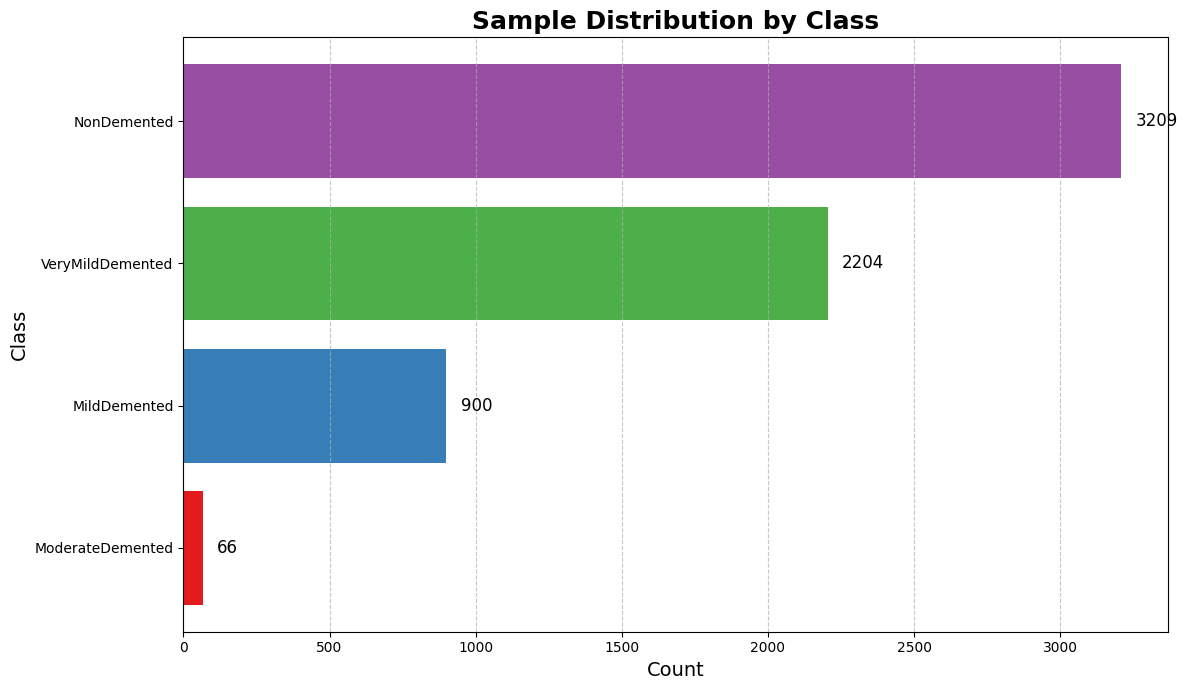

In [ ]:
# Visualize the number of samples for each class in the dataset

plt.figure(figsize=(15, 8))

# Create a count plot for the 'label' column
ax = sns.countplot(x=df.label, palette='Set1')

# Set axis labels and title
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class', fontsize=20)

# Add grid lines and rotate x-axis labels for readability
plt.grid(True)
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Step 4: Displaying Sample MRI Images from the Dataset

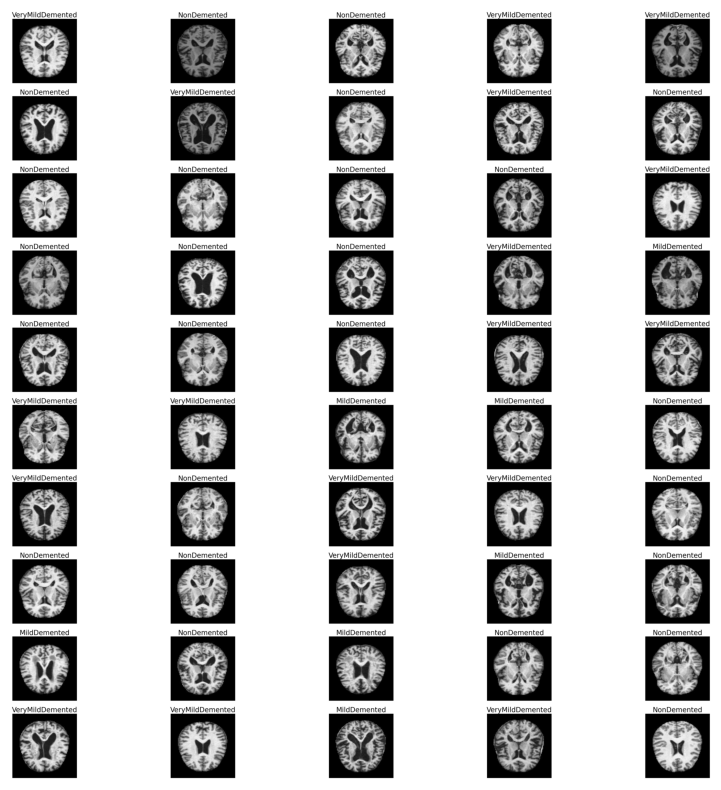

In [ ]:
# Display a random sample of 50 images from the dataset in a 10x5 grid

plt.figure(figsize=(50, 50))

# Randomly select 50 image indices
for n, i in enumerate(np.random.randint(0, len(df), 50)):
    plt.subplot(10, 5, n + 1)

    # Read and preprocess the image
    img = cv2.imread(df.image[i])
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i], fontsize=25)

# Render the entire grid
plt.show()

## Step 5: Image Preprocessing and Data Augmentation

In [ ]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [ ]:
train_data, train_labels = train_data_gen.next()

In [ ]:
class_num=np.sort(['Alzheimer_s disease','Cognitively normal','Early mild cognitive impairment','Late mild cognitive impairment'])
class_num

array(['Alzheimer_s disease', 'Cognitively normal',
       'Early mild cognitive impairment',
       'Late mild cognitive impairment'], dtype='<U31')


## Step 6: Balancing the Dataset with SMOTE and Splitting into Train/Validation/Test Sets

In [ ]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


<ipython-input-22-d94127f064ad>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Class", y="Count", data=df, palette=custom_colors)


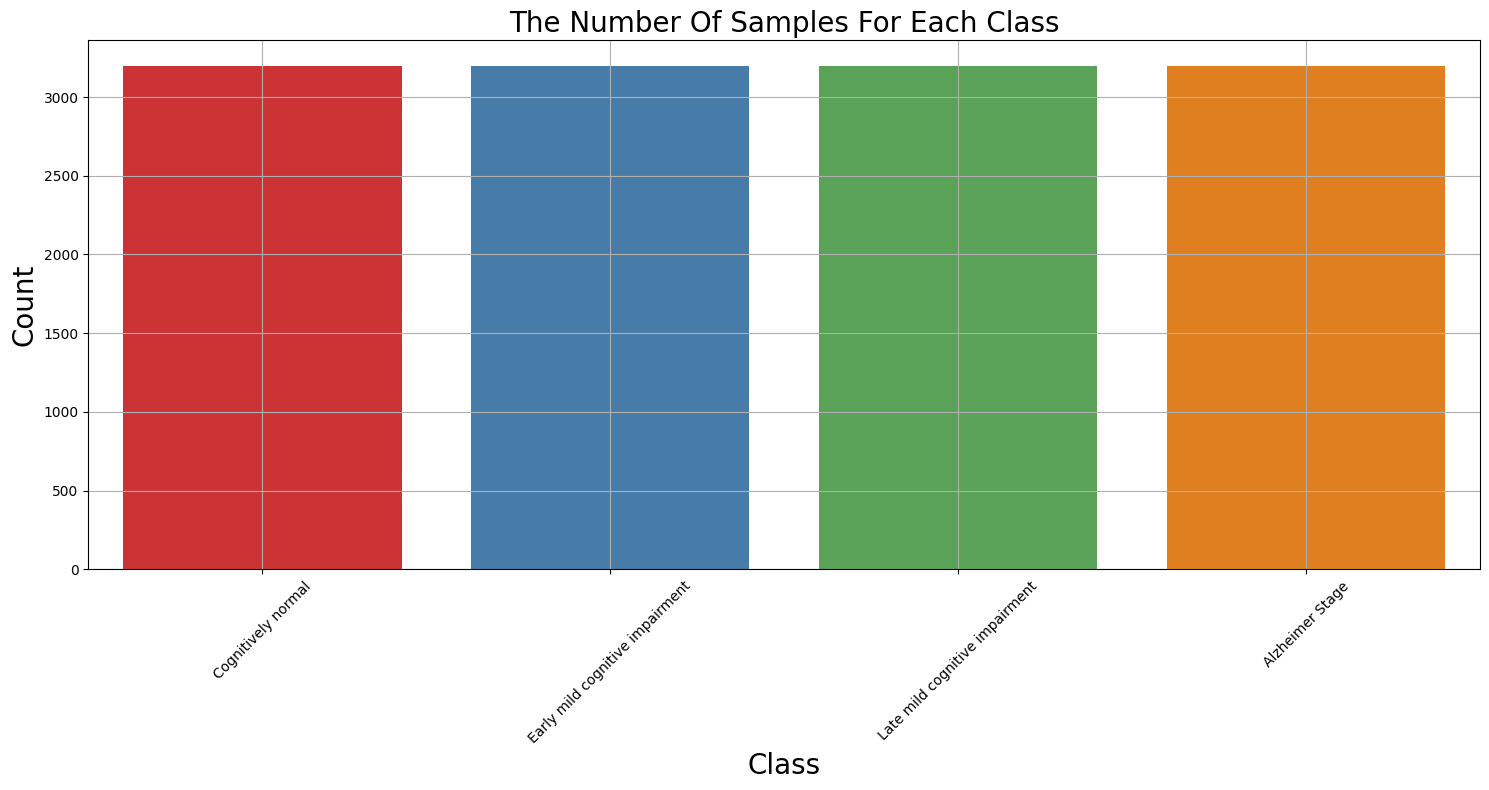

In [ ]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is   (1920, 176, 176, 3)
y_train shape is (8960, 4)
y_test shape is  (1920, 4)
y_val shape is   (1920, 4)


## Step 7: Building the Convolutional Neural Network (CNN)

In [ ]:
# Define a Convolutional Neural Network using Keras Sequential API

model = keras.models.Sequential()

# First convolutional block
model.add(keras.layers.Conv2D(
    32, kernel_size=(3, 3), strides=2, padding='same',
    activation='relu', input_shape=(176, 176, 3)
))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

# Second convolutional block
model.add(keras.layers.Conv2D(
    64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'
))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

# Third convolutional block
model.add(keras.layers.Conv2D(
    128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'
))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

# Flatten and Dense layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.3))  # Regularization to reduce overfitting
model.add(keras.layers.Dense(4, activation='softmax'))  # Output layer for 4 classes

# Display model architecture summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D) (None, 44, 44, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling2D) (None, 11, 11, 64)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling2D) (None, 3, 3, 128)      0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

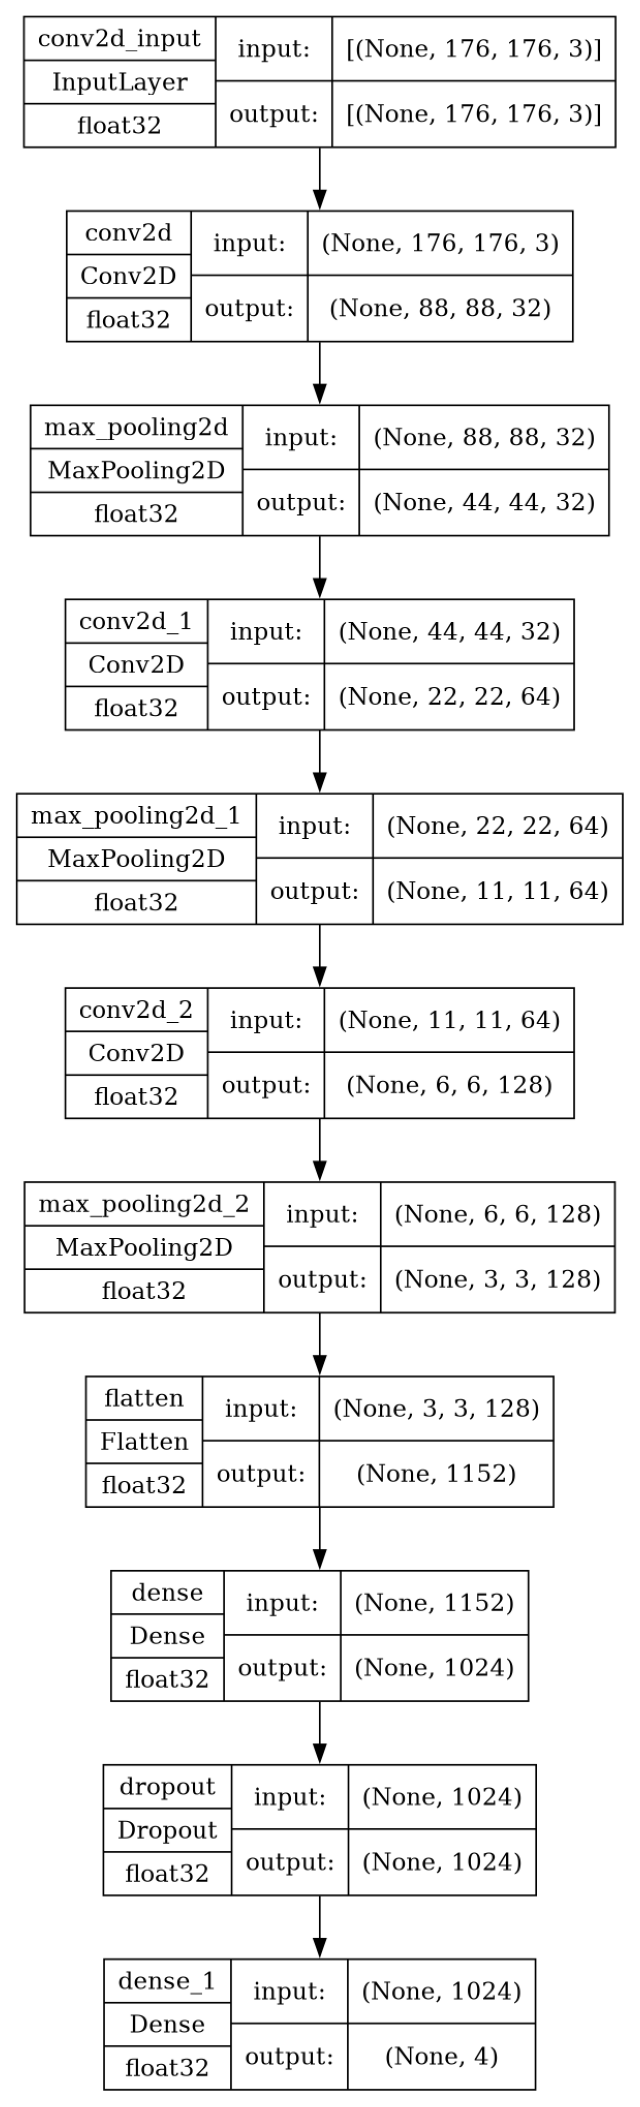

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

## Step 8: Compiling and Training the CNN Model

In [ ]:
checkpoint_cb =ModelCheckpoint("CNN_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
280/280 [==============================] - 16s 19ms/step - loss: 0.8191 - accuracy: 0.6105 - val_loss: 0.5623 - val_accuracy: 0.7167
Epoch 2/50
 11/280 [>.............................] - ETA: 2s - loss: 0.4339 - accuracy: 0.8324
/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
280/280 [==============================] - 3s 12ms/step - loss: 0.3939 - accuracy: 0.8220 - val_loss: 0.2846 - val_accuracy: 0.8823
Epoch 3/50
280/280 [==============================] - 3s 12ms/step - loss: 0.2248 - accuracy: 0.9050 - val_loss: 0.2078 - val_accuracy: 0.9177
Epoch 4/50
280/280 [==============================] - 3s 12ms/step - loss: 0.1275 - accuracy: 0.9497 - val_loss: 0.2340 - val_accuracy: 0.9115
Epoch 5/50
280/280 [===================

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

epoch   loss      accuracy  val_loss  val_accuracy
0       0.819105  0.610491  0.562320  0.716667
1       0.393863  0.821987  0.284573  0.882292
2       0.224756  0.905022  0.207774  0.917708
3       0.127463  0.949665  0.234030  0.911458
4       0.099001  0.960603  0.189244  0.936458
5       0.053299  0.981250  0.308779  0.907292
6       0.053153  0.981250  0.084595  0.969792
7       0.021016  0.991741  0.094672  0.969792
8       0.037254  0.987723  0.057898  0.977083
9       0.040186  0.985826  0.100754  0.963021
10      0.029183  0.988504  0.144250  0.956250
11      0.032722  0.989397  0.070030  0.973958
12      0.023962  0.991406  0.068624  0.975000
13      0.023367  0.991406  0.059765  0.979688
14      0.029470  0.990513  0.078425  0.973958
15      0.024376  0.991295  0.082821  0.969792
16      0.017937  0.992634  0.058108  0.983333
17      0.016063  0.994196  0.112648  0.967708
18      0.027661  0.990960  0.059901  0.978646
19      0.010573  0.996203  0.051482  0.986129
20      0

## Step 9: Visualizing Training and Validation Loss/Accuracy

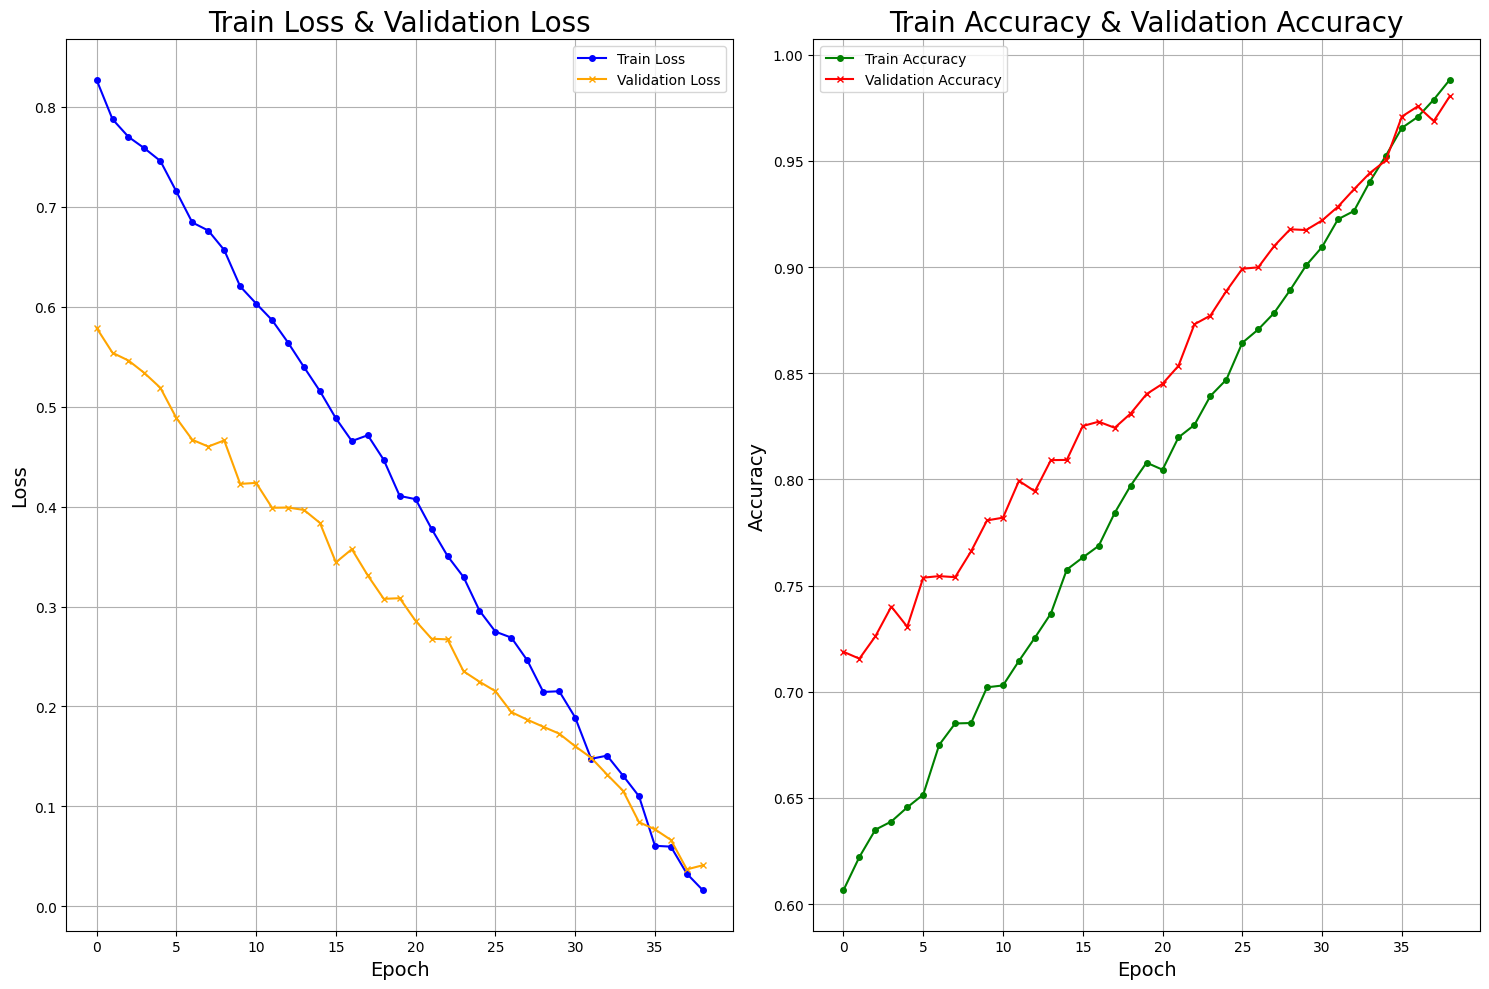

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

## Step 10: Evaluating the Model on Test Data

In [ ]:
score, acc = model.evaluate(X_test, y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 1s 8ms/step - loss: 0.0428 - accuracy: 0.9844
Test Loss = 0.04284399747848511
Test Accuracy = 0.984375


## Step 11: Generating Predictions and Viewing Model Outputs

In [ ]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 [==============================] - 1s 6ms/step
   Actual  Prediction
0       1           1
1       3           3
2       2           2
3       2           2
4       0           0
...
      Actual  Prediction
1915       2           2
1916       3           3
1917       2           2
1918       1           1
1919       1           1

1920 rows × 2 columns


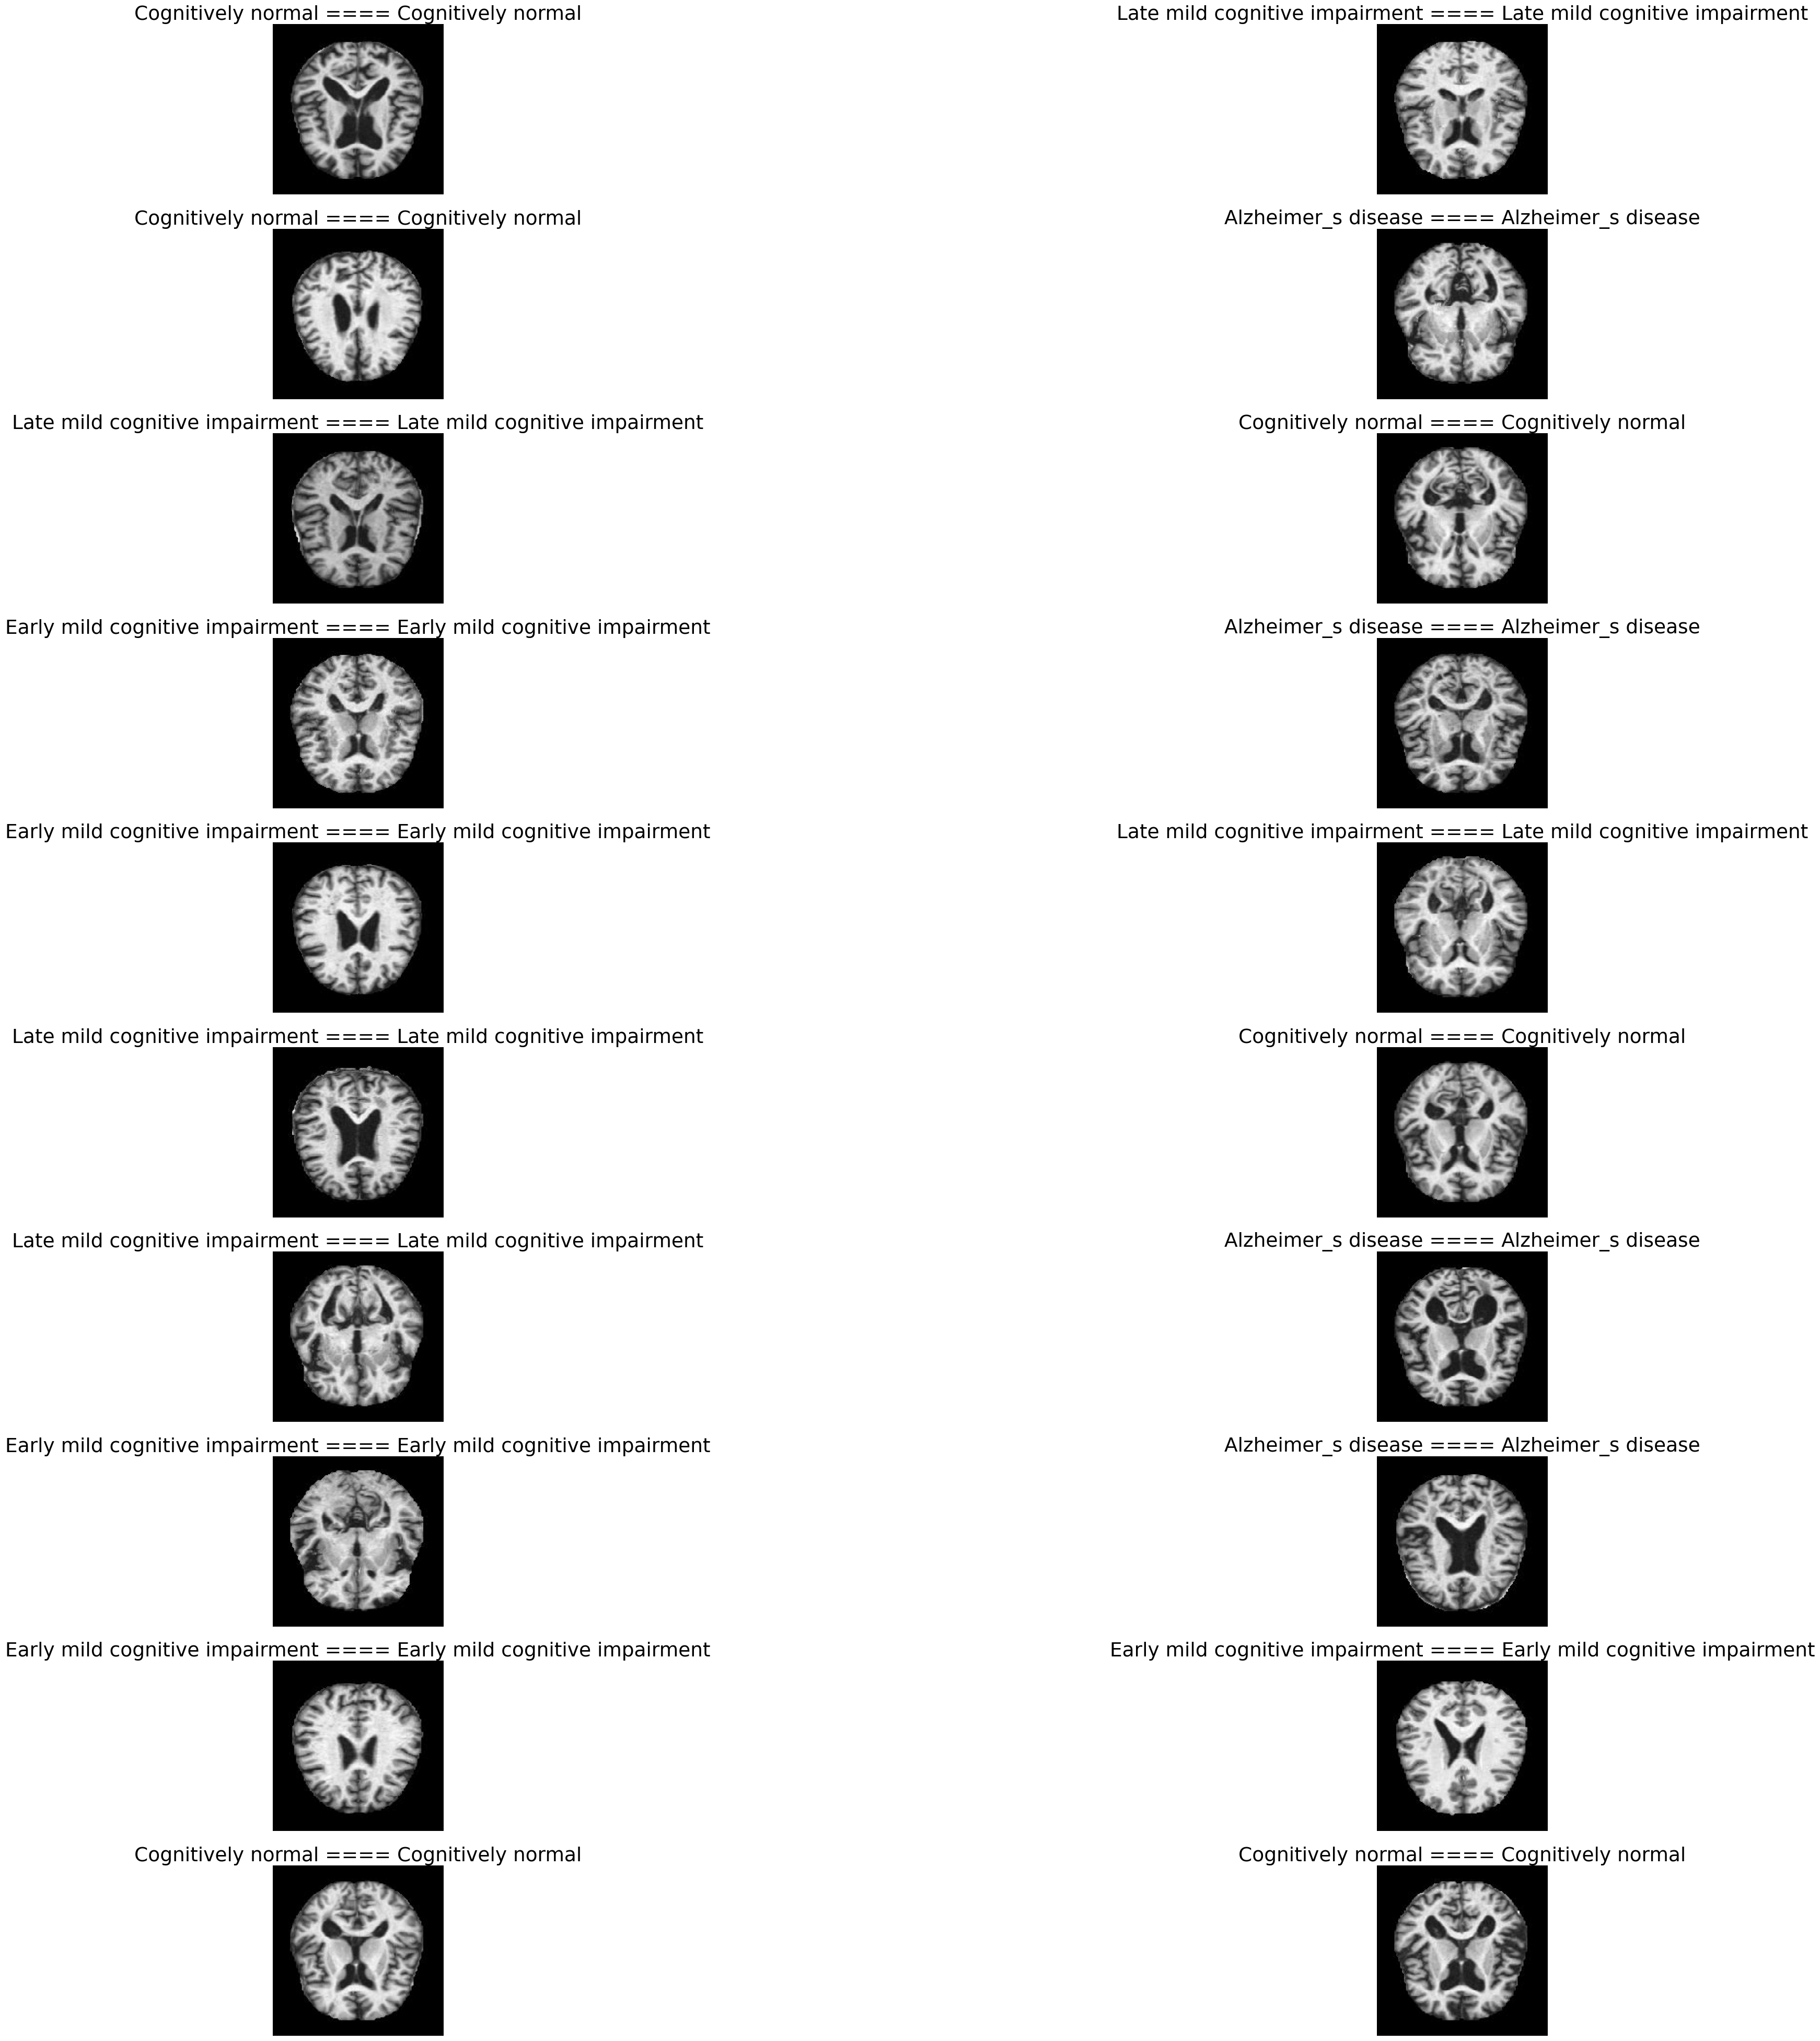

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),20)):
    plt.subplot(10,2,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} ==== {class_num[y_pred[i]]}',fontsize=27)

## Step 12: Generating the Classification Report


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(
    y_test_, y_pred,
    target_names=[
        'Cognitively normal (0)',
        'Early mild cognitive impairment (1)',
        'Late mild cognitive impairment (2)',
        'Alzheimer\'s disease (3)'
    ]
)
print("Classification Report is :\n", report)

Classification Report is :                precision    recall  f1-score   support

           0       0.99      0.99      0.99       480
           1       1.00      1.00      1.00       480
           2       0.96      0.98      0.97       480
           3       0.99      0.96      0.97       480

    accuracy                           0.98      1920
   macro avg       0.99      0.98      0.98      1920
weighted avg       0.99      0.98      0.98      1920


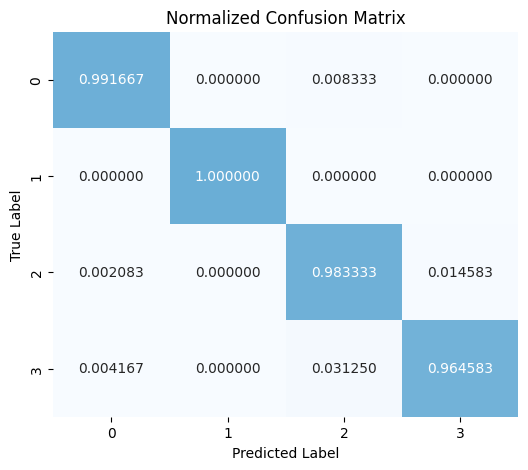

In [ ]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      0.99      0.99       480
           1       1.00      1.00      1.00       480
           2       0.96      0.98      0.97       480
           3       0.99      0.96      0.97       480

    accuracy                           0.98      1920
   macro avg       0.99      0.98      0.98      1920
weighted avg       0.99      0.98      0.98      1920


## Step 14: Summary & Conclusion

This project focused on building a deep learning model to classify Alzheimer's disease stages using brain MRI images. Here's a quick summary:

### Key Steps:
- **Loaded and explored** an image dataset containing 4 classes: Cognitively Normal, Early Mild Cognitive Impairment, Late Mild Cognitive Impairment, and Alzheimer’s Disease.
- **Visualized** class distribution and sample images.
- **Preprocessed** images and **balanced** the dataset using SMOTE to address class imbalance.
- **Built** a CNN model with 3 convolutional layers followed by dense layers.
- **Trained** the model with early stopping and checkpoint callbacks.
- **Achieved** high accuracy:
  - **Validation Accuracy:** ~98.9%
  - **Test Accuracy:** 98.4%
- **Evaluated** the model using classification report and normalized confusion matrix.

### Final Results:
- Excellent precision, recall, and F1-score across all classes.
- Very low misclassification rate, particularly in differentiating early/mild stages of cognitive decline.

### Conclusion:
This CNN model demonstrates strong potential in assisting early detection of Alzheimer’s disease using MRI scans. With further tuning and more diverse data, it could become a reliable diagnostic aid in clinical settings.

